# Labolatorium 4

### Autorzy:
Patryk Klatka \
Wojciech Łoboda


### Algorytm permutacji macierzy - Minimum degree

#### Pseudokod

#### Implementacja

In [4]:
from collections import deque
import networkx as nx

def minimum_degree_permutation(matrix):
    n,m = matrix.shape
    ADJ = {i:set() for i in range(n)}
    for i in range(n):
        for j in range(m):
            if matrix[i][j] != 0 and i != j:
                ADJ[i].add(j)
    permutation = []
    for i in range(n):
        deg_min = m+1
        for v, adj in ADJ.items():
            if len(adj) < deg_min:
                v_min = v
                deg_min = len(adj)
        for v in ADJ:
            ADJ[v] = ADJ[v].difference([v_min])
        for u in ADJ[v_min]:
            ADJ[u] = (ADJ[u].union(ADJ[v_min].difference([u])))
        ADJ.pop(v_min)
        permutation.append(v_min)
    return permutation

def cuthill_mckee(matrix):

    def BFS():
        while Q:
            v = Q.popleft()
            if Visited[v]:
                continue
            permutation.append(v)
            Visited[v] = True
            for u in sorted(nx.neighbors(G, v), key = lambda x : G.degree(x)):
                if not Visited[u]:
                    Q.append(u)
    n = len(matrix)
    
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    for i in range(n):
        for j in range(n):
            if matrix[i][j] != 0 and i != j:
                G.add_edge(i, j)

    permutation = []
    Visited = [False for i in range(n)]
    sorted_nodes = sorted([x for x in G.degree()], key = lambda x : x[1])
    # print(sorted_nodes)
    sorted_nodes = list(map(lambda x : x[0], sorted_nodes))
    Q = deque()
    for s in sorted_nodes:
        if not Visited[s]:
            Q.append(s)
            BFS()
    return permutation


def permutate(matrix, permutation):
    new_matrix = matrix.copy()
    for i in range(len(permutation)):
        if i == permutation[i]:
            continue
        new_matrix[i,:] = matrix[permutation[i],:].copy()

    matrix = new_matrix.copy()
    for i in range(len(permutation)):
        if i == permutation[i]:
            continue
        new_matrix[:,i] = matrix[:,permutation[i]].copy()

    return new_matrix

#### Generacja macierzy opisującej topologie siatki 3d

In [10]:
import numpy as np

def generate(k):
    n = 2 ** (3 * k)
    M = np.zeros((n, n))
    jumps = [0, -1, 1, -2**(k), 2**(k), -2**(k*2), 2**(k*2)]
    for v in range(n):
        for j in jumps:
            if v + j >= 0 and v + j < n:
                M[v][v + j] = 1
    return M * np.random.random((n, n))

# def generate_3d_matrix(k):
#     n = 2**(k*3)
#     X = np.random.random((n, n))
#     P = np.zeros_like(X)
#     big_jump = 2**(2*k)
#     small_jump = 2**k
#     jumps = [0] + [2**(i*k) for i in range(3)]
#     for a in range(2**k):
#         A = big_jump * a
#         for b in range(2**k):
#             B = small_jump * b
#             for c in range(2**k):
#                 v = P[A + B + c]
#                 if a > 0:
#                     v[A + B + c - big_jump] = 1
#                 if a < 2**k - 1:
#                     v[A + B + c + big_jump] = 1
#                 if b > 0:
#                     v[A + B + c - small_jump] = 1
#                 if b < 2**k - 1:
#                     v[A + B + c + small_jump] = 1
#                 if c > 0:
#                     v[A + B + c - 1] = 1
#                 if c < 2**k - 1:
#                     v[A + B + c + 1] = 1
                
#     return X * P

#### Kompresja macierzy do macierzy hierarchicznej (poprzedni lab)

In [17]:
from sklearn.utils.extmath import randomized_svd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from collections import deque


class MatrixTree:
    def __init__(self, matrix, row_min, row_max, col_min, col_max):
        self.matrix = matrix
        self.row_min = row_min
        self.row_max = row_max
        self.col_min = col_min
        self.col_max = col_max
        self.leaf = False
        self.children = None


    def compress(self, r, eps):
        U, Sigma, V = randomized_svd(self.matrix[self.row_min:self.row_max, self.col_min: self.col_max], n_components=r+1, random_state=0)
        if self.row_min + r == self.row_max or Sigma[r] <= eps:
            self.leaf = True
            if not self.matrix[self.row_min:self.row_max, self.col_min: self.col_max].any():
                self.rank = 0
            else:
                self.rank = len(Sigma)
                self.u = U
                self.s = Sigma
                self.v = V
        else:
            self.children = []
            row_newmax = (self.row_min + self.row_max)//2
            col_newmax = (self.col_min + self.col_max)//2
            self.children.append(MatrixTree(self.matrix, self.row_min, row_newmax, self.col_min, col_newmax))
            self.children.append(MatrixTree(self.matrix, self.row_min, row_newmax, col_newmax, self.col_max))
            self.children.append(MatrixTree(self.matrix, row_newmax, self.row_max, self.col_min, col_newmax))
            self.children.append(MatrixTree(self.matrix, row_newmax, self.row_max, col_newmax, self.col_max))

            for child in self.children:
                child.compress(r, eps)
    
    def decompress(self, output_matrix):
        if self.leaf:
            if self.rank != 0:
                sigma = np.zeros((self.rank,self.rank))
                np.fill_diagonal(sigma, self.s)
                output_matrix[self.row_min:self.row_max, self.col_min: self.col_max] = self.u @ sigma @ self.v #zeros
            else:
                output_matrix[self.row_min:self.row_max, self.col_min: self.col_max] = self.matrix[self.row_min:self.row_max, self.col_min: self.col_max]
        else:
            for child in self.children:
                child.decompress(output_matrix)

    def compute_compression_ratio_(self):
        if self.leaf:
            x = self.row_max - self.row_min
            y = self.col_max - self.col_min
            #return self.rank * len(self.u) * 2, x * y
            if self.rank != 0: 
                n = len(self.s)
                area = 2*n*len(self.u)+n
                return area, x * y
                #return self.rank * len(self.u) * 2, x * y
                #return len(self.u) + len(self.v) + len(self.s), (x * y)
            else:
                return 0, (x * y)
        v, s = 0, 0
        for child in self.children:
            res = child.compute_compression_ratio_()
            v += res[0]
            s += res[1]
        return v, s
    
    def compute_compression_ratio(self):
        v, s = self.compute_compression_ratio_()
        print("RATIO", v, s)
        #return s / v
        return v / (4*s)

def draw_tree(root, title=''):
    image = np.ones(root.matrix.shape)*255
    Q = deque()
    Q.append(root)
    while Q:
        v = Q.pop()
        if v.leaf:
            image[v.row_min:v.row_max, v.col_min:v.col_min+v.rank] = np.zeros((v.row_max - v.row_min, v.rank))
            image[v.row_min:v.row_min+v.rank, v.col_min:v.col_max] = np.zeros((v.rank , v.col_max - v.col_min))
            image[v.row_min, v.col_min:v.col_max] = np.zeros((1,v.col_max - v.col_min))
            image[v.row_max-1, v.col_min:v.col_max] = np.zeros((1,v.col_max - v.col_min))
            image[v.row_min:v.row_max,v.col_min] = np.zeros(v.row_max-v.row_min)
            image[v.row_min:v.row_max,v.col_max-1] = np.zeros(v.row_max-v.row_min)
        else:
            for child in v.children:
                Q.append(child)

    plt.imshow(image, cmap="gist_gray", vmin=0, vmax=255)
    plt.title(title)
    plt.show()

def compress_matrix(M):
    k = M.shape[0]
    eps = randomized_svd(M, n_components=k, random_state=0)[1][k // 2]#k - 1
    root = MatrixTree(M, 0, k, 0, k)
    root.compress(1, eps)
    return root



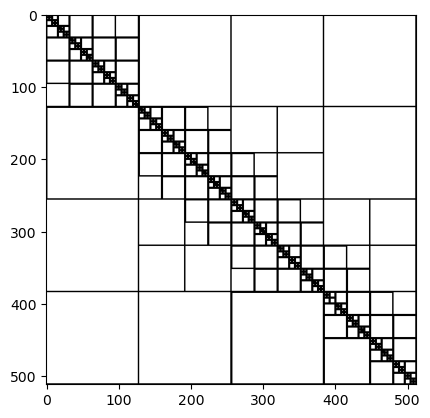

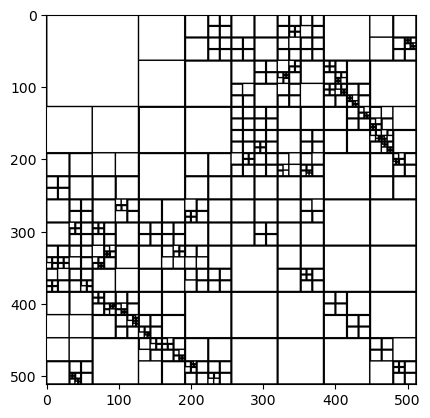

RATIO 17056 262144
RATIO 32002 262144
0.016265869140625 0.030519485473632812


In [18]:
k = 3
M = generate(k)
perm = minimum_degree_permutation(M)
Mp = permutate(M.copy(), perm)

r = compress_matrix(M)
rp = compress_matrix(Mp)

draw_tree(r)
draw_tree(rp)

print(r.compute_compression_ratio(), rp.compute_compression_ratio())